In [1]:
import pandas as pd
import seaborn as sns

# Cargar ambos CSV
df = pd.read_csv('churn-bigml-80.csv')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

# Custom DropColumn
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(self.cols, axis=1)

# Función para graficar matriz de confusión
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Clase 0', 'Clase 1'],
                yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.tight_layout()
    plt.show()

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class AddSumOfColumnsColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns, constant=0, name='AddedColumns'):
        self.columns = columns
        self.constant = constant
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        added_series = X_copy[self.columns].sum(axis=1) + self.constant
        added_series.name = self.name
        return pd.concat([X_copy, added_series], axis=1)

class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, method='iqr'):
        self.columns = columns
        self.method = method
        self.medians_ = {}

    def fit(self, X, y=None):
        X_ = X.copy()
        if self.columns is None:
            self.columns = X_.select_dtypes(include=np.number).columns.tolist()
        for col in self.columns:
            self.medians_[col] = X_[col].median()
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            if self.method == 'iqr':
                Q1 = X_[col].quantile(0.25)
                Q3 = X_[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                # Reemplazar por la mediana si está fuera de los límites
                median = self.medians_[col]
                X_.loc[(X_[col] < lower_bound) | (X_[col] > upper_bound), col] = median
        return X_

# Business Value
def calcular_business_value(conf_matrix_df, clientes_estimados=1200, anios=5):
    tn = conf_matrix_df.loc["Actual No Churn", "Predicted No Churn"]
    fp = conf_matrix_df.loc["Actual No Churn", "Predicted Churn"]
    fn = conf_matrix_df.loc["Actual Churn", "Predicted No Churn"]
    tp = conf_matrix_df.loc["Actual Churn", "Predicted Churn"]

    clientes_estimados_n = clientes_estimados * anios

    ganancia_tn = clientes_estimados_n * tn
    perdida_fp = -0.2 * fp * clientes_estimados_n
    perdida_fn = -clientes_estimados_n * fn
    costo_tp = -0.2 * tp * clientes_estimados_n

    total_neto = ganancia_tn + perdida_fp + perdida_fn + costo_tp

    return {
        "ganancia_tn": ganancia_tn,
        "perdida_fp": perdida_fp,
        "perdida_fn": perdida_fn,
        "costo_tp": costo_tp,
        "total_neto": total_neto
    }

def plot_confusion_matrix(cm, title='Matriz de Confusión', labels=['No Churn', 'Churn']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Pred {l}' for l in labels],
                yticklabels=[f'Real {l}' for l in labels])
    plt.title(title)
    plt.ylabel('Valor real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

In [3]:
# 2. Target como entero si es booleano
y = df['Churn'].astype(int)
X = df.drop(columns=['Churn'])

In [4]:
# Definir las variables por tipo
categoricas = ['State', 'International plan', 'Voice mail plan']
enteras = [
    'Account length', 'Area code', 'Number vmail messages',
    'Total day calls', 'Total eve calls', 'Total night calls',
    'Total intl calls', 'Customer service calls'
]
continuas = [
    'Total day minutes', 'Total day charge',
    'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge',
    'Total intl minutes', 'Total intl charge'
]

# Asignar tipos
for col in categoricas:
    df[col] = df[col].astype('category')

for col in enteras:
    df[col] = df[col].astype('int64')

for col in continuas:
    df[col] = df[col].astype('float64')

df['Churn'] = df['Churn'].astype(bool)

## Hipotesis Inicial

In [5]:
# Separar las características y la variable objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

# Identificar las columnas categóricas y numéricas
categorical_cols = ['State', 'International plan', 'Voice mail plan']
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Crear transformadores para las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0  # Asegurar que la salida sea densa
)

# Crear un pipeline que incluya el preprocesador y el clasificador
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Realizar la validación cruzada de 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf)

# Entrenar el clasificador en el conjunto de entrenamiento completo
pipeline.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)

# Generar el informe de clasificación
classification_metrics = classification_report(y_test, y_pred)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Etiquetar las filas y columnas de la matriz de confusión
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])

print(f"Precisión del clasificador Naive Bayes: {accuracy * 100:.2f}%")
print(f"Puntuaciones de validación cruzada de 10 pliegues: {cv_scores}")
print(f"Puntuación media de validación cruzada: {cv_scores.mean() * 100:.2f}%")
print("Informe de clasificación:")
print(classification_metrics)
print("Matriz de confusión etiquetada:")
print(conf_matrix_df)

resultado = calcular_business_value(conf_matrix_df)

Precisión del clasificador Naive Bayes: 54.50%
Puntuaciones de validación cruzada de 10 pliegues: [0.55614973 0.4973262  0.56684492 0.49197861 0.45989305 0.5828877
 0.46774194 0.55376344 0.56989247 0.48387097]
Puntuación media de validación cruzada: 52.30%
Informe de clasificación:
              precision    recall  f1-score   support

       False       0.88      0.54      0.67       683
        True       0.17      0.56      0.27       117

    accuracy                           0.55       800
   macro avg       0.53      0.55      0.47       800
weighted avg       0.78      0.55      0.61       800

Matriz de confusión etiquetada:
                 Predicted No Churn  Predicted Churn
Actual No Churn                 370              313
Actual Churn                     51               66


## Exploracion de H6

### Hipotesis Inicial

In [6]:
# Copiar base para H6
H6 = df.copy()

# Crear nueva columna Total charge sumando los tres cargos
H6["Total charge"] = (
    H6["Total day charge"] +
    H6["Total eve charge"] +
    H6["Total night charge"]
)

# Eliminar columnas originales si ya no se necesitan
H6.drop(columns=["Total day charge", "Total eve charge", "Total night charge"], inplace=True)

H6_encoded = pd.get_dummies(H6.drop(columns=['Churn']), drop_first=True)

# 2. Target como entero si es booleano
y_h6 = H6['Churn'].astype(int)
X_h6 = H6_encoded

X_h6_train, X_h6_test, y_h6_train, y_h6_test = train_test_split(X_h6, y_h6, test_size=0.3, random_state=42)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definir el modelo base
h6_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h6_random_search = RandomizedSearchCV(
    h6_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h6_random_search.fit(X_h6_train, y_h6_train)

# Mejor modelo
best_rf_h6 = h6_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h6_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h6, X_h6, y_h6, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h6_y_train_pred = best_rf_h6.predict(X_h6_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h6_train, rf_h6_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h6_train, rf_h6_y_train_pred))

# Predicción
rf_h6_y_test_pred = best_rf_h6.predict(X_h6_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h6_test, rf_h6_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h6_test, rf_h6_y_test_pred))

🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 289}
📈 Puntuaciones de cada fold (10-fold CV):
[0.9375     0.97058824 1.         1.         1.         0.94594595
 0.96666667 0.96774194 1.         1.        ]

📊 Precisión promedio: 97.88%
📉 Desviación estándar: 2.32%

📊 Precisión (positive class) en train: 98.28%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1595
           1       0.98      0.84      0.91       271

    accuracy                           0.97      1866
   macro avg       0.98      0.92      0.95      1866
weighted avg       0.98      0.97      0.97      1866


📊 Precisión (positive class) en test: 100.00%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       683
           1       1.00      0.74      0.85       117

In [7]:
# Resultados finales
h6_conf_matrix = confusion_matrix(y_h6_test, rf_h6_y_test_pred)
h6_conf_matrix_df = pd.DataFrame(h6_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h6_resultado = calcular_business_value(h6_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h6 = h6_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h6 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h6 = h6_resultado["perdida_fp"] + h6_resultado["perdida_fn"] + h6_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h6)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h6) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h6}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h6}")

Mejora en ganancia neta: 161.02% - Ganancia h0: 1459200.0 - Nueva Ganancia: 3808800.0
Reducción en pérdida total: 61.99% - Pérdida h0: -760800.0 - Nueva Pérdida: -289200.0


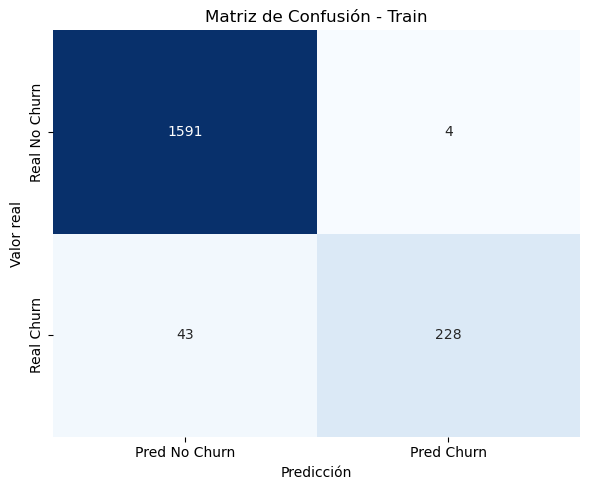

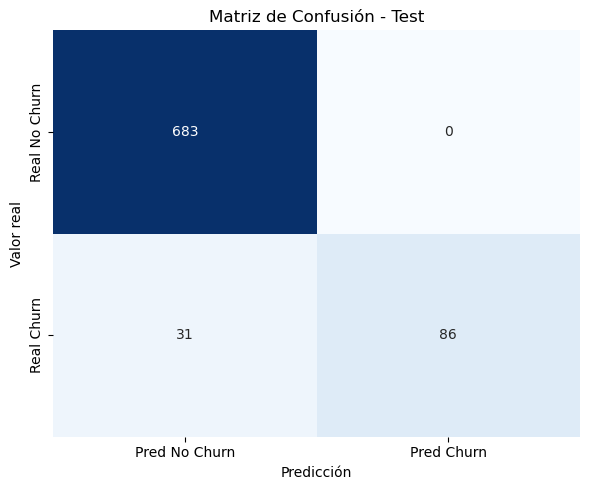

In [8]:
# 🔵 Matriz de confusión en TRAIN
h6_conf_matrix_train = confusion_matrix(y_h6_train, rf_h6_y_train_pred)
plot_confusion_matrix(h6_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h6_conf_matrix)
plot_confusion_matrix(h6_conf_matrix, title="Matriz de Confusión - Test")

### Ramas

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
1361,AZ,109,415,Yes,No,0,268.4,85,45.63,150.6,131,12.80,297.9,84,13.41,9.7,8,2.62,2
908,KS,167,415,No,No,0,131.6,120,22.37,211.3,96,17.96,168.3,97,7.57,11.1,4,3.00,4
230,MI,137,510,No,No,0,206.4,122,35.09,128.0,102,10.88,194.5,84,8.75,8.8,5,2.38,2
1788,ID,134,415,No,No,0,204.7,108,34.80,143.1,105,12.16,165.8,84,7.46,11.0,4,2.97,6
2248,ID,151,415,No,No,0,194.8,106,33.12,292.7,103,24.88,224.6,82,10.11,5.5,3,1.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,CT,97,415,No,No,0,215.3,58,36.60,242.4,91,20.60,279.8,105,12.59,12.1,9,3.27,0
1095,NY,40,510,No,No,0,115.7,105,19.67,127.8,113,10.86,107.5,91,4.84,9.3,6,2.51,1
1130,ND,60,510,No,No,0,203.2,99,34.54,235.8,131,20.04,224.9,112,10.12,15.1,6,4.08,2
1294,ND,84,510,No,No,0,226.9,144,38.57,201.6,122,17.14,130.2,121,5.86,13.2,5,3.56,2


In [11]:
columnas_sin_importancia_h6=['State','Area code','Total day calls', 'Total eve calls', 'Total night calls']

In [12]:
columnas_alta_correlacion_h6=['Total intl minutes','Total night minutes','Total eve minutes','Total day minutes']

In [13]:
columnas_alta_correlacion=['Total intl minutes','Total night minutes','Total eve minutes','Total day minutes']

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 6, 'rf_model__max_features': 'log2', 'rf_model__min_samples_leaf': 6, 'rf_model__min_samples_split': 11, 'rf_model__n_estimators': 103}

📊 Precisión en Train: 0.9914163090128756
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.98      1.00      0.99      1595
        True       0.99      0.85      0.92       271

    accuracy                           0.98      1866
   macro avg       0.98      0.93      0.95      1866
weighted avg       0.98      0.98      0.98      1866



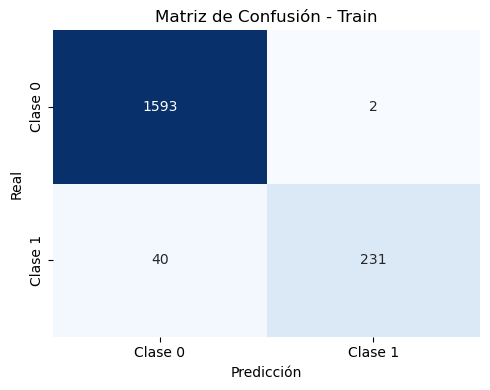


📊 Precisión en Test: 1.0
🧾 Classification Report (Test):
               precision    recall  f1-score   support

       False       0.96      1.00      0.98       683
        True       1.00      0.76      0.86       117

    accuracy                           0.96       800
   macro avg       0.98      0.88      0.92       800
weighted avg       0.97      0.96      0.96       800



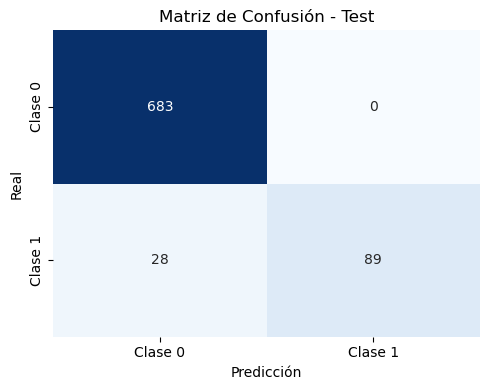

In [14]:
multicolumn_prep_h6 = Pipeline([
    ('add_total_charge', AddSumOfColumnsColumn(
        columns=['Total day charge', 'Total eve charge', 'Total night charge'],
        name='Total charge'
    )),
    ('drop1', DropColumn(cols=columnas_sin_importancia_h6)),
    ('drop2', DropColumn(cols=columnas_alta_correlacion_h6)),
    ('drop3', DropColumn(cols=['Total day charge', 'Total eve charge', 'Total night charge'])),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan']),
            ('scale', MinMaxScaler(), [
                'Account length',
                'Number vmail messages',
                'Total intl calls',
                'Total intl charge',
                'Customer service calls',
                'Total charge'
            ])
        ],
        remainder='passthrough'
    ))
])


# Pipeline completo
h6_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_h6),
    #('pca', PCA(n_components=4)),
    ('rf_model', RandomForestClassifier(random_state=42))
])

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Randomized Search
h6_random_search = RandomizedSearchCV(
    h6_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h6_random_search.fit(X_train, y_train)

# Mejor pipeline entrenado
best_h6_pipeline = h6_random_search.best_estimator_

print("🔧 Mejores hiperparámetros encontrados:")
print(h6_random_search.best_params_)

# === EVALUACIÓN EN TRAIN ===
y_rh6_train_pred = best_h6_pipeline.predict(X_train)
print("\n📊 Precisión en Train:", precision_score(y_train, y_rh6_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh6_train_pred))
plot_confusion(y_train, y_rh6_train_pred, "Matriz de Confusión - Train")

# === EVALUACIÓN EN TEST ===
y_rh6_test_pred = best_h6_pipeline.predict(X_test)
print("\n📊 Precisión en Test:", precision_score(y_test, y_rh6_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh6_test_pred))
plot_confusion(y_test, y_rh6_test_pred, "Matriz de Confusión - Test")

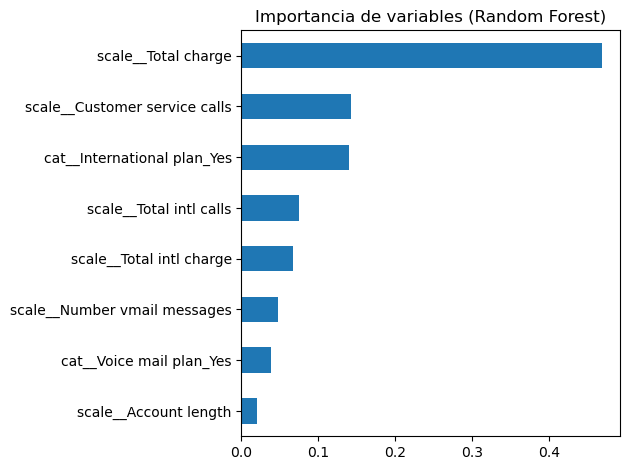

In [15]:
# Obtener el modelo RandomForest desde el pipeline
rf_model = best_h6_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_h6_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [16]:
# Resultados finales
rh6_conf_matrix = confusion_matrix(y_test, y_rh6_test_pred)
rh6_conf_matrix_df = pd.DataFrame(rh6_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh6_resultado = calcular_business_value(rh6_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh6 = rh6_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh6 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh6 = rh6_resultado["perdida_fp"] + rh6_resultado["perdida_fn"] + rh6_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh6)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh6) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia H6: {ganancia_h6} - Ganancia RH6: {ganancia_rh6}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida H6: {perdida_h6} - Pérdida RH6: {perdida_rh6}")

Mejora en ganancia neta: 162.01% - Ganancia h0: 1459200.0 - Ganancia H6: 3808800.0 - Ganancia RH6: 3823200.0
Reducción en pérdida total: 63.88% - Pérdida h0: -760800.0 - Pérdida H6: -289200.0 - Pérdida RH6: -274800.0


In [17]:
def evaluar_ganancia_perdida(ganancia_h0, ganancia_h6, ganancia_rh6,
                              perdida_h0, perdida_h6, perdida_rh6,nh):
    # Calcular mejoras porcentuales
    mejora_ganancia_pct = ((ganancia_rh6 - ganancia_h0) / ganancia_h0) * 100
    reduccion_perdida_pct = ((perdida_h0 - perdida_rh6) / abs(perdida_h0)) * 100

    # Imprimir resultados
    #print(f"🔹 Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0:,.0f} - Ganancia H6: {ganancia_h6:,.0f} - Ganancia RH6: {ganancia_rh6:,.0f}")
    #print(f"🔸 Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0:,.0f} - Pérdida H6: {perdida_h6:,.0f} - Pérdida RH6: {perdida_rh6:,.0f}")

    # Datos para graficar
    modelos = ['H0', f'H{nh}', f'RH{nh}']
    ganancias = [ganancia_h0, ganancia_h6, ganancia_rh6]
    perdidas = [perdida_h0, perdida_h6, perdida_rh6]

    x = np.arange(len(modelos))
    width = 0.35

    # Gráfico
    fig, ax = plt.subplots(figsize=(13, 5))
    bars1 = ax.bar(x - width/2, ganancias, width, label='Ganancia Neta', color='steelblue')
    bars2 = ax.bar(x + width/2, perdidas, width, label='Pérdida Total', color='indianred')

    ax.set_ylabel('Monto en S/.')
    #ax.set_title('Comparativo de Ganancia Neta y Pérdida Total por Modelo')
    ax.set_xticks(x)
    ax.set_xticklabels(modelos)
    ax.legend()
    ax.axhline(0, color='black', linewidth=0.8)

    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval,
                f'{int(yval):,}', ha='center',
                va='bottom' if yval > 0 else 'top', fontsize=9)

    plt.tight_layout()
    plt.show()

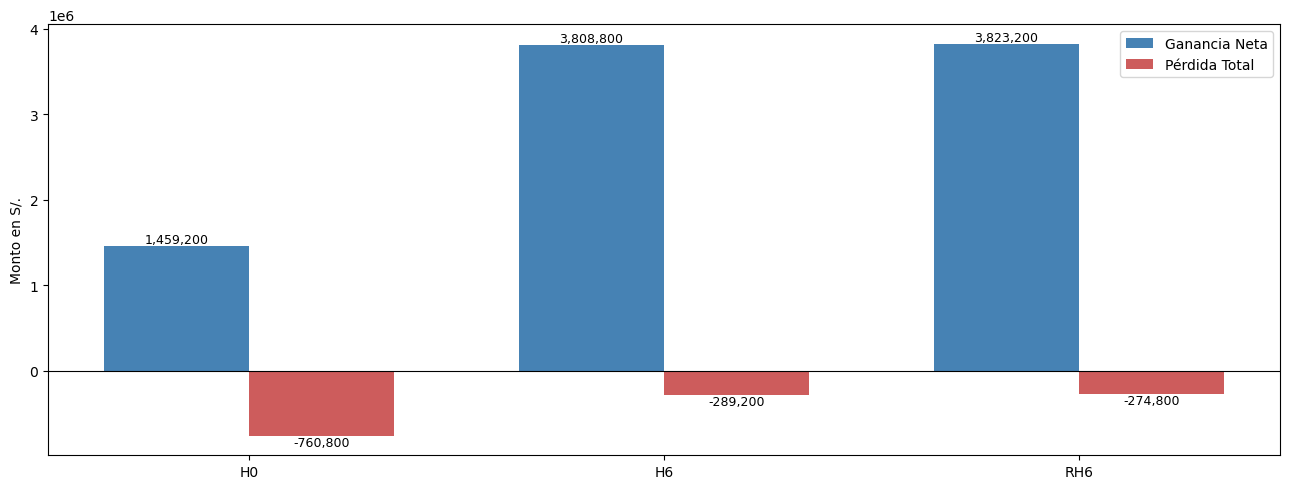

In [18]:
evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h6,
    ganancia_rh6,
    perdida_h0,
    perdida_h6,
    perdida_rh6,
    6
)

#### Permutation Importance

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

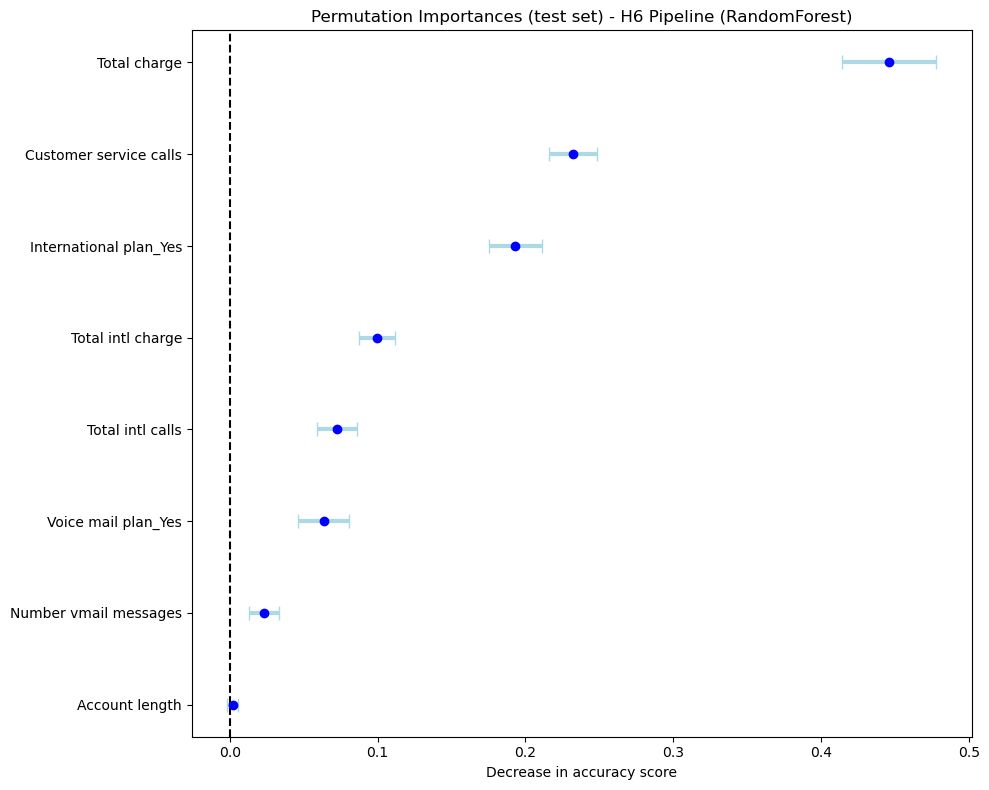

In [20]:
multicolumn_prep_pi_h6 = Pipeline([
    ('add_total_charge', AddSumOfColumnsColumn(
        columns=['Total day charge', 'Total eve charge', 'Total night charge'],
        name='Total charge'
    )),
    ('drop1', DropColumn(cols=columnas_sin_importancia_h6)),
    ('drop2', DropColumn(cols=columnas_alta_correlacion_h6)),
    ('drop3', DropColumn(cols=['Total day charge', 'Total eve charge', 'Total night charge'])),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan']),
            ('scale', MinMaxScaler(), [
                'Account length',
                'Number vmail messages',
                'Total intl calls',
                'Total intl charge',
                'Customer service calls',
                'Total charge'
            ])
        ],
        remainder='passthrough'
    ))
])


# Pipeline completo
pi_h6_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_pi_h6),
    #('pca', PCA(n_components=4)),
    ('rf_model', RandomForestClassifier(random_state=42))
])

pi_h6_pipeline.fit(X_train, y_train)

# Extraer modelo ya entrenado
rf_model = pi_h6_pipeline.named_steps['rf_model']

# Transformar X_test con el preprocesamiento del pipeline
X_test_transformed = pi_h6_pipeline.named_steps['preprocessing'].transform(X_test)

# Extraer nombres de features después de transformación
preprocessor = pi_h6_pipeline.named_steps['preprocessing'].named_steps['encode']
cat_features = ['International plan', 'Voice mail plan']
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)

num_features = [
    'Account length', 'Number vmail messages', 'Total intl calls',
    'Total intl charge', 'Customer service calls', 'Total charge'
]

# Resto de columnas (passthrough) — si tienes identificadas
passthrough_features = preprocessor.remainder  # puede ser 'passthrough' o una lista si la defines

# Final list
all_feature_names = list(encoded_cat_names) + num_features  # + passthrough_features si las sabes

# Permutation Importance
result = permutation_importance(
    rf_model, X_test_transformed, y_test,
    n_repeats=30,
    random_state=42,
    scoring='f1'
)

# Crear DataFrame con importancias
importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=True)

# Graficar
plt.figure(figsize=(10, 8))
plt.errorbar(
    importances_df.importance_mean,
    importances_df.feature,
    xerr=importances_df.importance_std,
    fmt='o',
    color='blue',
    ecolor='lightblue',
    elinewidth=3,
    capsize=5
)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Decrease in accuracy score')
plt.title('Permutation Importances (test set) - H6 Pipeline (RandomForest)')
plt.tight_layout()
plt.show()

In [21]:
# Nuevas columnas a eliminar por baja importancia en Permutation Importance
pi_h6_columnas_sin_importancia = [
]

# Agregarlas al array existente (evitando duplicados si es necesario)
n_columnas_importancia_h6 = list(set(columnas_sin_importancia_h6 + pi_h6_columnas_sin_importancia))

grid_multicolumn_prep_h6 = Pipeline([
    ('add_total_charge', AddSumOfColumnsColumn(
        columns=['Total day charge', 'Total eve charge', 'Total night charge'],
        name='Total charge'
    )),
    ('drop1', DropColumn(cols=n_columnas_importancia_h6)),
    ('drop2', DropColumn(cols=columnas_alta_correlacion_h6)),
    ('drop3', DropColumn(cols=['Total day charge', 'Total eve charge', 'Total night charge'])),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan','Voice mail plan']),
            ('scale', MinMaxScaler(), [
                'Total intl calls',
                'Total intl charge',
                'Customer service calls',
                'Total charge','Number vmail messages','Account length'
            ])
        ],
        remainder='passthrough'
    ))
])


# Pipeline completo
grid_h6_pipeline = Pipeline([
    ('preprocessing', grid_multicolumn_prep_h6),
    #('pca', PCA(n_components=4)),
    ('rf_model', RandomForestClassifier(random_state=42))
])

grid_search_h6 = GridSearchCV(
    grid_h6_pipeline,
    param_grid={
    'rf_model__n_estimators': [90, 100, 103, 110],         # centrado en 103
    'rf_model__max_depth': [5, 6, 7],                           # rango compacto
    'rf_model__min_samples_split': [9, 10, 11, 12, 13],         # +/- 2 del óptimo
    'rf_model__min_samples_leaf': [4, 5, 6, 7, 8],              # +/- 2 del óptimo
    'rf_model__max_features': ['log2', 'sqrt']                 # mantiene log2, prueba sqrt por si acaso
    },
    scoring='f1',
    cv=10,
    n_jobs=-1,
    verbose=2
)

grid_search_h6.fit(X_train, y_train)

print("🏆 Mejor combinación de hiperparámetros encontrada:")
print(grid_search_h6.best_params_)

print(f"\n🎯 Mejor F1-score promedio (cross-validation): {grid_search_h6.best_score_:.4f}")


Fitting 10 folds for each of 600 candidates, totalling 6000 fits
[CV] END rf_model__max_depth=5, rf_model__max_features=log2, rf_model__min_samples_leaf=4, rf_model__min_samples_split=9, rf_model__n_estimators=90; total time=   0.2s
[CV] END rf_model__max_depth=5, rf_model__max_features=log2, rf_model__min_samples_leaf=4, rf_model__min_samples_split=9, rf_model__n_estimators=90; total time=   0.2s
[CV] END rf_model__max_depth=5, rf_model__max_features=log2, rf_model__min_samples_leaf=4, rf_model__min_samples_split=9, rf_model__n_estimators=90; total time=   0.2s
[CV] END rf_model__max_depth=5, rf_model__max_features=log2, rf_model__min_samples_leaf=4, rf_model__min_samples_split=9, rf_model__n_estimators=90; total time=   0.2s
[CV] END rf_model__max_depth=5, rf_model__max_features=log2, rf_model__min_samples_leaf=4, rf_model__min_samples_split=9, rf_model__n_estimators=90; total time=   0.2s
[CV] END rf_model__max_depth=5, rf_model__max_features=log2, rf_model__min_samples_leaf=4, rf_m

In [22]:

from sklearn.metrics import classification_report, confusion_matrix

# === Evaluación en TEST ===
h6_cv_y_pred_test = grid_search_h6.predict(X_test)
print("🧪 TEST SET")
print("🧾 Classification report (test):\n", classification_report(y_test, h6_cv_y_pred_test))
print("📊 Confusion matrix (test):\n", confusion_matrix(y_test, h6_cv_y_pred_test))

# === Evaluación en TRAIN ===
h6_cv_y_pred_train = grid_search_h6.predict(X_train)
print("\n🏋️ TRAINING SET")
print("🧾 Classification report (train):\n", classification_report(y_train, h6_cv_y_pred_train))
print("📊 Confusion matrix (train):\n", confusion_matrix(y_train, h6_cv_y_pred_train))

# Mejor combinación de hiperparámetros
print("✅ Best params found:\n", grid_search_h6.best_params_)

🧪 TEST SET
🧾 Classification report (test):
               precision    recall  f1-score   support

       False       0.96      1.00      0.98       683
        True       1.00      0.74      0.85       117

    accuracy                           0.96       800
   macro avg       0.98      0.87      0.92       800
weighted avg       0.96      0.96      0.96       800

📊 Confusion matrix (test):
 [[683   0]
 [ 30  87]]

🏋️ TRAINING SET
🧾 Classification report (train):
               precision    recall  f1-score   support

       False       0.98      1.00      0.99      1595
        True       0.99      0.85      0.92       271

    accuracy                           0.98      1866
   macro avg       0.98      0.93      0.95      1866
weighted avg       0.98      0.98      0.98      1866

📊 Confusion matrix (train):
 [[1593    2]
 [  40  231]]
✅ Best params found:
 {'rf_model__max_depth': 6, 'rf_model__max_features': 'log2', 'rf_model__min_samples_leaf': 4, 'rf_model__min_samples_split

In [23]:
# Matriz de confusión como DataFrame para análisis económico
cv_rh6_conf_matrix = confusion_matrix(y_test, h6_cv_y_pred_test)
cv_rh6_conf_matrix_df = pd.DataFrame(
    cv_rh6_conf_matrix,
    index=['Actual No Churn', 'Actual Churn'],
    columns=['Predicted No Churn', 'Predicted Churn']
)

# Calcular resultados de negocio
cv_rh6_resultado = calcular_business_value(cv_rh6_conf_matrix_df)

# === Cálculo de ganancias ===
ganancia_h0 = resultado["total_neto"]
ganancia_h6 = h6_resultado["total_neto"]
ganancia_rh6 = rh6_resultado["total_neto"]
ganancia_cv_rh6 = cv_rh6_resultado["total_neto"]

# === Cálculo de pérdidas ===
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h6 = h6_resultado["perdida_fp"] + h6_resultado["perdida_fn"] + h6_resultado["costo_tp"]
perdida_rh6 = rh6_resultado["perdida_fp"] + rh6_resultado["perdida_fn"] + rh6_resultado["costo_tp"]
perdida_cv_rh6 = cv_rh6_resultado["perdida_fp"] + cv_rh6_resultado["perdida_fn"] + cv_rh6_resultado["costo_tp"]

# === Comparaciones relativas respecto al baseline ===
def calc_mejora(base, nuevo):
    return ((nuevo - base) / abs(base)) * 100

# === Diccionario resumen ===
resumen_modelos = pd.DataFrame({
    'Modelo': ['h0 (Baseline)', 'h6', 'rh6', 'cv_rh6'],
    'Ganancia Neta': [ganancia_h0, ganancia_h6, ganancia_rh6, ganancia_cv_rh6],
    'Pérdida Total': [perdida_h0, perdida_h6, perdida_rh6, perdida_cv_rh6],
    'Mejora Ganancia %': [
        0,
        calc_mejora(ganancia_h0, ganancia_h6),
        calc_mejora(ganancia_h0, ganancia_rh6),
        calc_mejora(ganancia_h0, ganancia_cv_rh6)
    ],
    'Reducción Pérdida %': [
        0,
        calc_mejora(perdida_h0, perdida_h6) * -1,
        calc_mejora(perdida_h0, perdida_rh6) * -1,
        calc_mejora(perdida_h0, perdida_cv_rh6) * -1
    ]
})

print(resumen_modelos.to_string(index=False))

       Modelo  Ganancia Neta  Pérdida Total  Mejora Ganancia %  Reducción Pérdida %
h0 (Baseline)      1459200.0      -760800.0           0.000000             0.000000
           h6      3808800.0      -289200.0         161.019737           -61.987382
          rh6      3823200.0      -274800.0         162.006579           -63.880126
       cv_rh6      3813600.0      -284400.0         161.348684           -62.618297


## H5: Agrupación ordinal de Account length en 3 niveles: bajo, medio, alto

### Hipotesis Inicial

In [24]:
# Copiar base para H5
H5 = df.copy()

# Crear variable ordinal: bajo, medio, alto según terciles
H5["AccountLengthLevel"] = pd.qcut(
    H5["Account length"],
    q=3,
    labels=[0, 1, 2]  # 0 = Bajo, 1 = Medio, 2 = Alto
).astype(int)

# Eliminar columna original si se desea
H5.drop(columns=["Account length"], inplace=True)

H5_encoded = pd.get_dummies(H5.drop(columns=['Churn']), drop_first=True)

# 2. Target como entero si es booleano
y_h5 = H5['Churn'].astype(int)
X_h5 = H5_encoded

X_h5_train, X_h5_test, y_h5_train, y_h5_test = train_test_split(X_h5, y_h5, test_size=0.3, random_state=42)


# Definir el modelo base
h5_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h5_random_search = RandomizedSearchCV(
    h5_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h5_random_search.fit(X_h5_train, y_h5_train)

# Mejor modelo
best_rf_h5 = h5_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h5_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h5, X_h5, y_h5, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h5_y_train_pred = best_rf_h5.predict(X_h5_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h5_train, rf_h5_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h5_train, rf_h5_y_train_pred))

# Predicción
rf_h5_y_test_pred = best_rf_h5.predict(X_h5_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h5_test, rf_h5_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h5_test, rf_h5_y_test_pred))

🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 222}
📈 Puntuaciones de cada fold (10-fold CV):
[0.87096774 0.93548387 0.93333333 0.89285714 0.87878788 0.83783784
 0.91666667 0.96153846 0.92592593 1.        ]

📊 Precisión promedio: 91.53%
📉 Desviación estándar: 4.47%

📊 Precisión (positive class) en train: 98.65%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1595
           1       0.99      0.81      0.89       271

    accuracy                           0.97      1866
   macro avg       0.98      0.90      0.94      1866
weighted avg       0.97      0.97      0.97      1866


📊 Precisión (positive class) en test: 95.06%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       683
           1       0.95      0.66      0.78       117



In [25]:
h5_conf_matrix = confusion_matrix(y_h5_test, rf_h5_y_test_pred)
h5_conf_matrix_df = pd.DataFrame(h5_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h5_resultado = calcular_business_value(h5_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h5 = h5_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h5 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h5 = h5_resultado["perdida_fp"] + h5_resultado["perdida_fn"] + h5_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h5)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h5) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

# Resultados finales
print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h5}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h5}")

Mejora en ganancia neta: 156.09% - Ganancia h0: 1459200.0 - Nueva Ganancia: 3736800.0
Reducción en pérdida total: 55.68% - Pérdida h0: -760800.0 - Nueva Pérdida: -337200.0


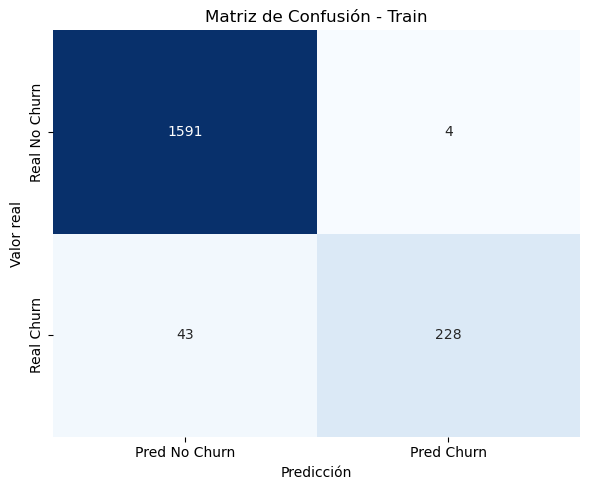

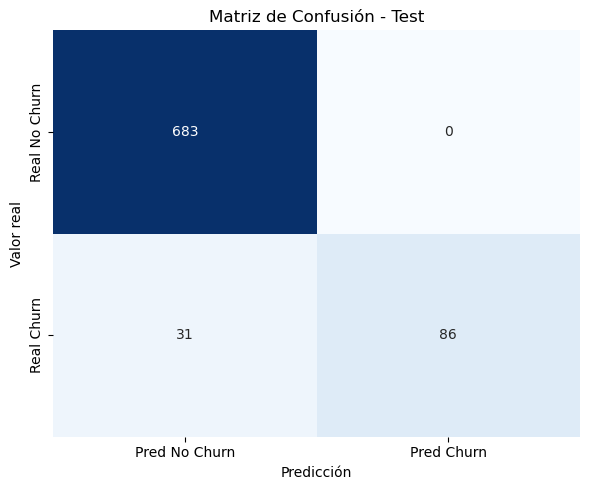

In [26]:
# 🔵 Matriz de confusión en TRAIN
h6_conf_matrix_train = confusion_matrix(y_h6_train, rf_h6_y_train_pred)
plot_confusion_matrix(h6_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h6_conf_matrix)
plot_confusion_matrix(h6_conf_matrix, title="Matriz de Confusión - Test")

### Rama

In [27]:
columnas_innecesarias_h5=['State','Area code']
columnas_transformar=['Account length']

In [28]:
columnas_filtradas = [col for col in df.columns
                      if col not in columnas_innecesarias_h5
                      and col not in columnas_alta_correlacion
                      and col not in columnas_transformar]
columnas_filtradas

['International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day calls',
 'Total day charge',
 'Total eve calls',
 'Total eve charge',
 'Total night calls',
 'Total night charge',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 6, 'rf_model__max_features': None, 'rf_model__min_samples_leaf': 6, 'rf_model__min_samples_split': 3, 'rf_model__n_estimators': 187}

📊 Precisión en Train: 0.9508928571428571
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.96      0.99      0.98      1595
        True       0.95      0.79      0.86       271

    accuracy                           0.96      1866
   macro avg       0.96      0.89      0.92      1866
weighted avg       0.96      0.96      0.96      1866



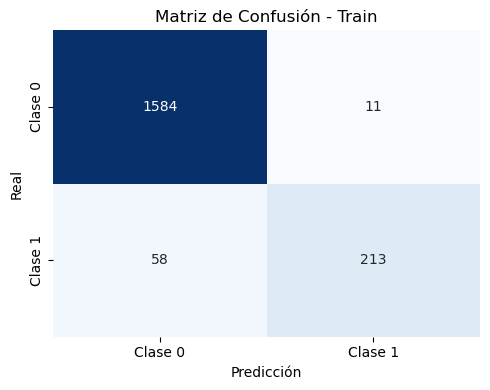


📊 Precisión en Test: 0.9036144578313253
🧾 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       683
           1       0.90      0.64      0.75       117

    accuracy                           0.94       800
   macro avg       0.92      0.81      0.86       800
weighted avg       0.94      0.94      0.93       800



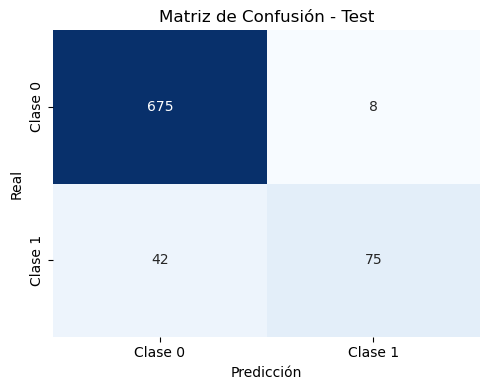

In [29]:
# Copiar base para H5
H5 = df.copy()

# Crear variable ordinal: bajo, medio, alto según terciles
H5["AccountLengthLevel"] = pd.qcut(
    H5["Account length"],
    q=3,
    labels=[0, 1, 2]  # 0 = Bajo, 1 = Medio, 2 = Alto
).astype(int)

# 2. Target como entero si es booleano
y_rh5 = H5['Churn'].astype(int)
X_rh5 = H5.drop(columns=['Churn'])


X_rh5_train, X_rh5_test, y_rh5_train, y_test = train_test_split(X_rh5, y_rh5, test_size=0.3, random_state=42)

# Nuevo pipeline de procesamiento rh5
multicolumn_prep_rh5 = Pipeline([
    ('drop1', DropColumn(cols=['Account length'])),
    ('drop2', DropColumn(cols=columnas_innecesarias_h5)),
    ('drop3', DropColumn(cols=columnas_alta_correlacion)),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan']),
            ('scale', MinMaxScaler(), [
'Number vmail messages',
 'Total day calls',
 'Total day charge',
 'Total eve calls',
 'Total eve charge',
 'Total night calls',
 'Total night charge',
 'Total intl calls',
 'Total intl charge'
            ])
        ],
        remainder='passthrough'
    ))
])

# Pipeline completo
rh5_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_rh5),
    ('rf_model', RandomForestClassifier(random_state=42))
])

# Hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Búsqueda aleatoria
rh5_random_search = RandomizedSearchCV(
    rh5_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
rh5_random_search.fit(X_rh5_train, y_rh5_train)
best_rh5_pipeline = rh5_random_search.best_estimator_

# Evaluación
y_rh5_train_pred = best_rh5_pipeline.predict(X_rh5_train)
y_rh5_test_pred = best_rh5_pipeline.predict(X_rh5_test)

print("🔧 Mejores hiperparámetros encontrados:")
print(rh5_random_search.best_params_)

print("\n📊 Precisión en Train:", precision_score(y_train, y_rh5_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh5_train_pred))
plot_confusion(y_train, y_rh5_train_pred, "Matriz de Confusión - Train")

print("\n📊 Precisión en Test:", precision_score(y_test, y_rh5_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh5_test_pred))
plot_confusion(y_test, y_rh5_test_pred, "Matriz de Confusión - Test")

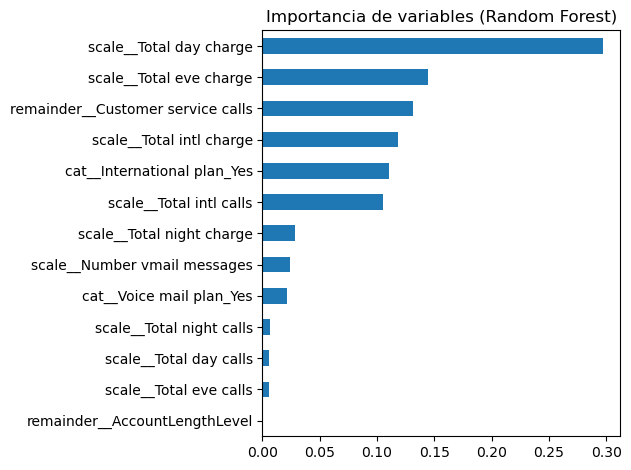

In [30]:
# Obtener el modelo RandomForest desde el pipeline
rf_model = best_rh5_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_rh5_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [31]:
# Resultados finales
rh5_conf_matrix = confusion_matrix(y_test, y_rh5_test_pred)
rh5_conf_matrix_df = pd.DataFrame(rh5_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh5_resultado = calcular_business_value(rh5_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh5 = rh5_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh5 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh5 = rh5_resultado["perdida_fp"] + rh5_resultado["perdida_fn"] + rh5_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh5)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh5) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia H5: {ganancia_h5} - Ganancia RH5: {ganancia_rh5}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida H5: {perdida_h5} - Pérdida RH5: {perdida_rh5}")

Mejora en ganancia neta: 153.45% - Ganancia h0: 1459200.0 - Ganancia H5: 3736800.0 - Ganancia RH5: 3698400.0
Reducción en pérdida total: 53.79% - Pérdida h0: -760800.0 - Pérdida H5: -337200.0 - Pérdida RH5: -351600.0


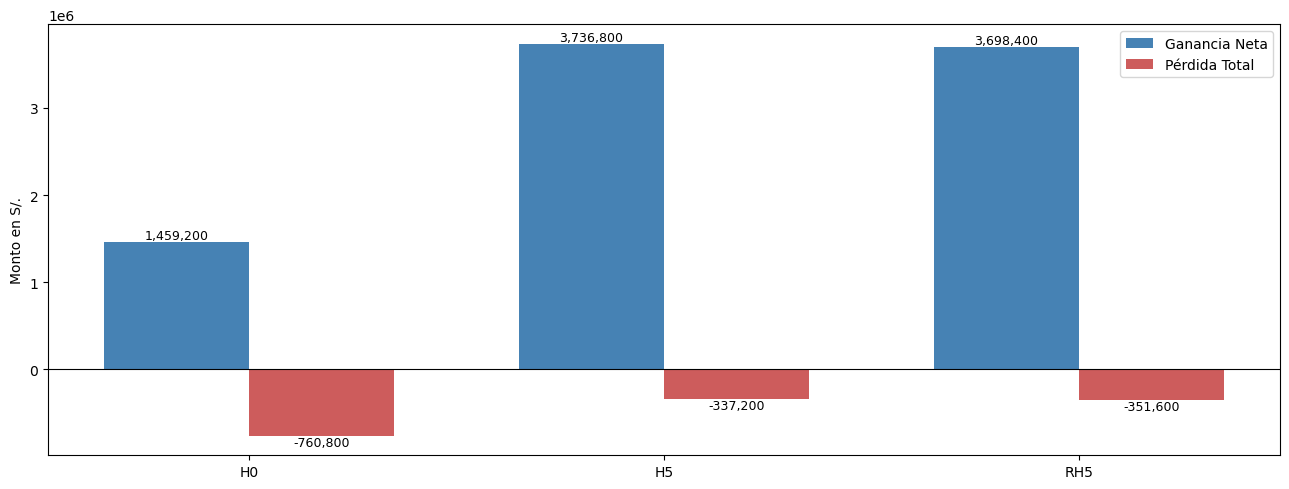

In [32]:
evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h5,
    ganancia_rh5,
    perdida_h0,
    perdida_h5,
    perdida_rh5,
    5
)

## H1: Agrupación de Customer service calls en niveles de fricción

### Hipotesis Inicial

In [33]:
H1 = df.copy()

H1["ServiceCallLevel"] = pd.cut(
    H1["Customer service calls"],
    bins=[-1, 2, 4, H1["Customer service calls"].max()],
    labels=[0, 1, 2]
).astype(int)

H1.drop(columns=["Customer service calls"], inplace=True)

H1_encoded = pd.get_dummies(H1.drop(columns=['Churn']), drop_first=True)

# 2. Target como entero si es booleano
y_h1 = H1['Churn'].astype(int)
X_h1 = H1_encoded

X_h1_train, X_h1_test, y_h1_train, y_h1_test = train_test_split(X_h1, y_h1, test_size=0.3, random_state=42)


from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definir el modelo base
h1_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h1_random_search = RandomizedSearchCV(
    h1_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h1_random_search.fit(X_h1_train, y_h1_train)

# Mejor modelo
best_rf_h1 = h1_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h1_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h1, X_h1, y_h1, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h1_y_train_pred = best_rf_h1.predict(X_h1_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h1_train, rf_h1_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h1_train, rf_h1_y_train_pred))

# Predicción
rf_h1_y_test_pred = best_rf_h1.predict(X_h1_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h1_test, rf_h1_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h1_test, rf_h1_y_test_pred))

h1_conf_matrix = confusion_matrix(y_h1_test, rf_h1_y_test_pred)
h1_conf_matrix_df = pd.DataFrame(h1_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h1_resultado = calcular_business_value(h1_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h1 = h1_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h1 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h1 = h1_resultado["perdida_fp"] + h1_resultado["perdida_fn"] + h1_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h1)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h1) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

# Resultados finales
print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h1}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h1}")

🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 222}
📈 Puntuaciones de cada fold (10-fold CV):
[0.95238095 0.96153846 0.83333333 0.86363636 0.92592593 0.87096774
 0.92307692 1.         1.         0.95454545]

📊 Precisión promedio: 92.85%
📉 Desviación estándar: 5.40%

📊 Precisión (positive class) en train: 100.00%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1595
           1       1.00      0.67      0.80       271

    accuracy                           0.95      1866
   macro avg       0.97      0.84      0.89      1866
weighted avg       0.95      0.95      0.95      1866


📊 Precisión (positive class) en test: 96.92%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       683
           1       0.97      0.54      0.69       117


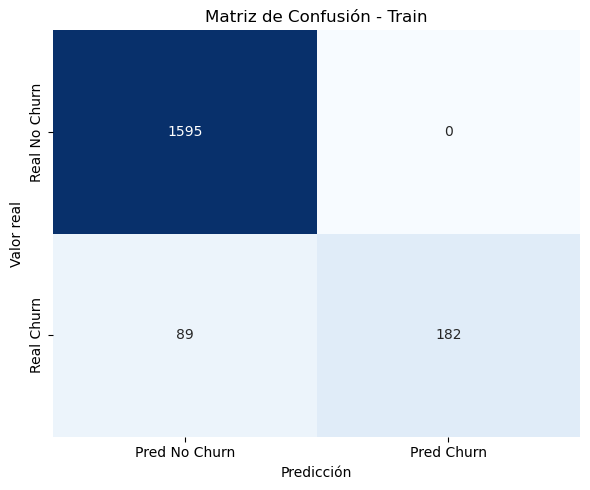

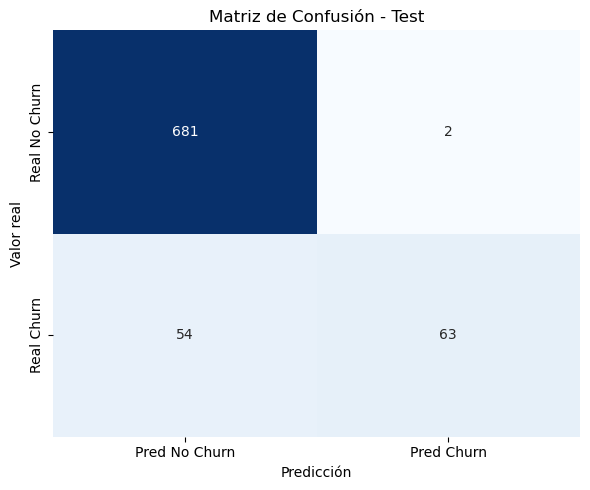

In [34]:
# 🔵 Matriz de confusión en TRAIN
h1_conf_matrix_train = confusion_matrix(y_h1_train, rf_h1_y_train_pred)
plot_confusion_matrix(h1_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h1_conf_matrix)
plot_confusion_matrix(h1_conf_matrix, title="Matriz de Confusión - Test")

### Rama Nivel 4

In [35]:
columnas_innecesarias_h1=['State','Area code','Account length','Total day calls','Total eve calls','Total night calls']
columnas_transforma_h1=['Customer service calls']

In [36]:
H1 = df.copy()

H1["ServiceCallLevel"] = pd.cut(
    H1["Customer service calls"],
    bins=[-1, 2, 4, H1["Customer service calls"].max()],
    labels=[0, 1, 2]  # 0 = Bajo, 1 = Medio, 2 = Alto
).astype(int)

# 2. Target como entero si es booleano
y_rh1 = H1['Churn'].astype(int)
X_rh1 = H1.drop(columns=['Churn'])


X_rh1_train, X_rh1_test, y_rh1_train, y_test = train_test_split(X_rh1, y_rh1, test_size=0.3, random_state=42)

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 6, 'rf_model__max_features': None, 'rf_model__min_samples_leaf': 6, 'rf_model__min_samples_split': 3, 'rf_model__n_estimators': 187}

📊 Precisión en Train: 0.947136563876652
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.97      0.99      0.98      1595
        True       0.95      0.79      0.86       271

    accuracy                           0.96      1866
   macro avg       0.96      0.89      0.92      1866
weighted avg       0.96      0.96      0.96      1866



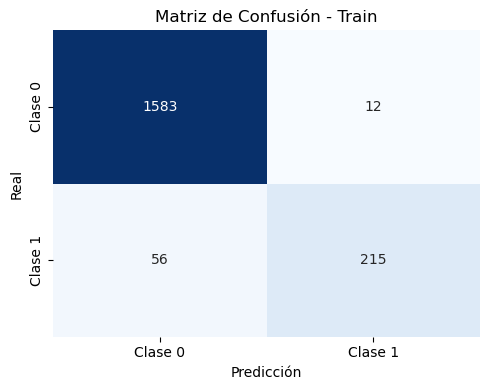


📊 Precisión en Test: 0.9156626506024096
🧾 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       683
           1       0.92      0.65      0.76       117

    accuracy                           0.94       800
   macro avg       0.93      0.82      0.86       800
weighted avg       0.94      0.94      0.94       800



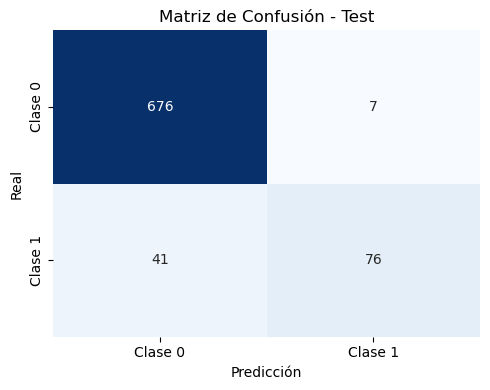

In [37]:
multicolumn_prep_rh1 = Pipeline([
    ('drop2', DropColumn(cols=columnas_innecesarias_h1)),
    ('drop3', DropColumn(cols=columnas_alta_correlacion)),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan']),
            ('scale', StandardScaler(), [
              'Number vmail messages',
              'Total day charge',
              'Total eve charge',
              'Total night charge',
              'Total intl calls',
              'Total intl charge'
            ])
        ],
        remainder='passthrough'
    ))
])

# Pipeline completo
rh1_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_rh1),
    ('rf_model', RandomForestClassifier(random_state=42))
])

# Hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Búsqueda aleatoria
rh1_random_search = RandomizedSearchCV(
    rh1_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
rh1_random_search.fit(X_train, y_train)
best_rh1_pipeline = rh1_random_search.best_estimator_

# Evaluación
y_rh1_train_pred = best_rh1_pipeline.predict(X_train)
y_rh1_test_pred = best_rh1_pipeline.predict(X_test)

print("🔧 Mejores hiperparámetros encontrados:")
print(rh1_random_search.best_params_)

print("\n📊 Precisión en Train:", precision_score(y_train, y_rh1_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh1_train_pred))
plot_confusion(y_train, y_rh1_train_pred, "Matriz de Confusión - Train")

print("\n📊 Precisión en Test:", precision_score(y_test, y_rh1_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh1_test_pred))
plot_confusion(y_test, y_rh1_test_pred, "Matriz de Confusión - Test")

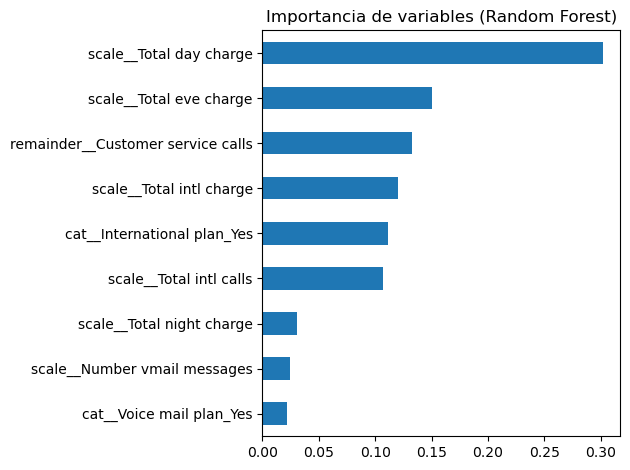

In [38]:
# Obtener el modelo RandomForest desde el pipeline
rf_rh1_model = best_rh1_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_rh1_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_rh1_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Mejora en ganancia neta: 154.28% - Ganancia h0: 1459200.0 - Ganancia H1: 3684000.0 - Ganancia RH1: 3710400.0
Reducción en pérdida total: 54.57% - Pérdida h0: -760800.0 - Pérdida H1: -402000.0 - Pérdida RH1: -345600.0


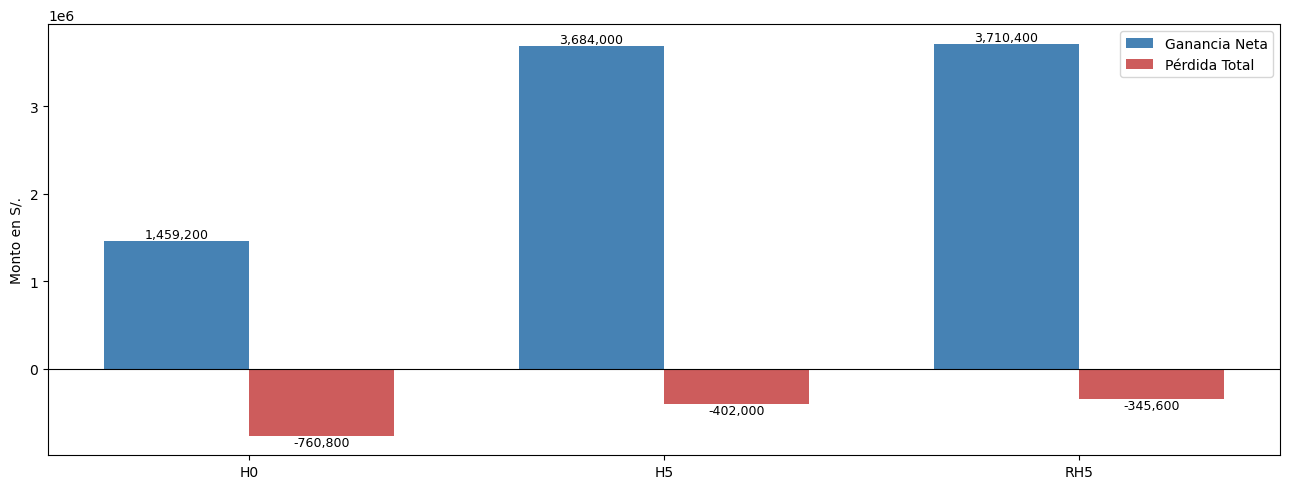

In [39]:
# Resultados finales
rh1_conf_matrix = confusion_matrix(y_test, y_rh1_test_pred)
rh1_conf_matrix_df = pd.DataFrame(rh1_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh1_resultado = calcular_business_value(rh1_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh1 = rh1_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh1 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh1 = rh1_resultado["perdida_fp"] + rh1_resultado["perdida_fn"] + rh1_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh1)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh1) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia H1: {ganancia_h1} - Ganancia RH1: {ganancia_rh1}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida H1: {perdida_h1} - Pérdida RH1: {perdida_rh1}")

evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h1,
    ganancia_rh1,
    perdida_h0,
    perdida_h1,
    perdida_rh1,
    5
)

## H7: Variable binaria HasIntPlanAndCalls → 1 si tiene plan internacional y hace llamadas internacionales

### Hipotesis Inicial

In [40]:
# Copiar base para H7
H7 = df.copy()


# Crear variable binaria: 1 si tiene plan internacional y ha hecho llamadas internacionales (>0)
H7["HasIntPlanAndCalls"] = ((H7["International plan"] == "Yes") & (H7["Total intl calls"] > 0)).astype(int)

print(H7[["International plan", "Total intl calls", "HasIntPlanAndCalls"]].head())

H7_encoded = pd.get_dummies(H7.drop(columns=['Churn']), drop_first=True)

# 2. Target como entero si es booleano
y_h7 = H7['Churn'].astype(int)
X_h7 = H7_encoded

X_h7_train, X_h7_test, y_h7_train, y_h7_test = train_test_split(X_h7, y_h7, test_size=0.3, random_state=42)



# Definir el modelo base
h7_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h7_random_search = RandomizedSearchCV(
    h7_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h7_random_search.fit(X_h7_train, y_h7_train)

# Mejor modelo
best_rf_h7 = h7_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h7_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h7, X_h7, y_h7, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h7_y_train_pred = best_rf_h7.predict(X_h7_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h7_train, rf_h7_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h7_train, rf_h7_y_train_pred))

# Predicción
rf_h7_y_test_pred = best_rf_h7.predict(X_h7_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h7_test, rf_h7_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h7_test, rf_h7_y_test_pred))

h7_conf_matrix = confusion_matrix(y_h7_test, rf_h7_y_test_pred)
h7_conf_matrix_df = pd.DataFrame(h7_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h7_resultado = calcular_business_value(h7_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h7 = h7_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h7 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h7 = h7_resultado["perdida_fp"] + h7_resultado["perdida_fn"] + h7_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h7)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h7) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

# Resultados finales
print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h7}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h7}")

  International plan  Total intl calls  HasIntPlanAndCalls
0                 No                 3                   0
1                 No                 3                   0
2                 No                 5                   0
3                Yes                 7                   1
4                Yes                 3                   1
🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 222}
📈 Puntuaciones de cada fold (10-fold CV):
[0.87096774 0.93548387 0.90322581 0.89285714 0.87878788 0.83783784
 0.91428571 0.96153846 0.92592593 1.        ]

📊 Precisión promedio: 91.21%
📉 Desviación estándar: 4.44%

📊 Precisión (positive class) en train: 98.66%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1595
           1       0.99      0.82      0.89       271

    accuracy                           0.97    

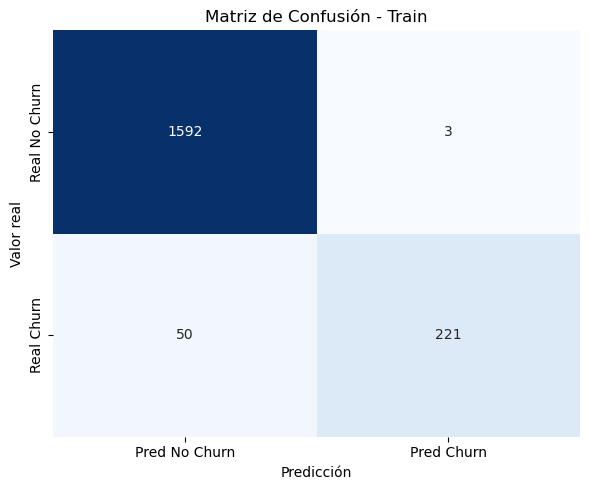

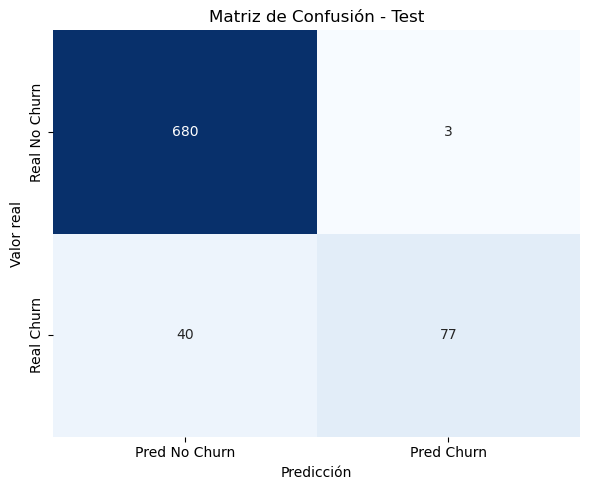

In [41]:
# 🔵 Matriz de confusión en TRAIN
h7_conf_matrix_train = confusion_matrix(y_h7_train, rf_h7_y_train_pred)
plot_confusion_matrix(h7_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h7_conf_matrix)
plot_confusion_matrix(h7_conf_matrix, title="Matriz de Confusión - Test")

### Rama Nivel 4

In [42]:
columnas_innecesarias_h7=['State','Area code','Account length','Total day calls','Total eve calls','Total night calls','International plan']

In [43]:
columnas_filtradas = [col for col in df.columns
                      if col not in columnas_innecesarias_h7
                      and col not in columnas_alta_correlacion]
columnas_filtradas

['Voice mail plan',
 'Number vmail messages',
 'Total day charge',
 'Total eve charge',
 'Total night charge',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 6, 'rf_model__max_features': None, 'rf_model__min_samples_leaf': 3, 'rf_model__min_samples_split': 2, 'rf_model__n_estimators': 222}

📊 Precisión en Train: 0.9911111111111112
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.97      1.00      0.98      1595
        True       0.99      0.82      0.90       271

    accuracy                           0.97      1866
   macro avg       0.98      0.91      0.94      1866
weighted avg       0.97      0.97      0.97      1866



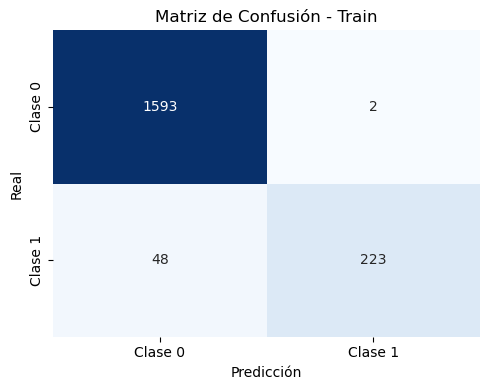


📊 Precisión en Test: 0.9518072289156626
🧾 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       683
           1       0.95      0.68      0.79       117

    accuracy                           0.95       800
   macro avg       0.95      0.83      0.88       800
weighted avg       0.95      0.95      0.94       800



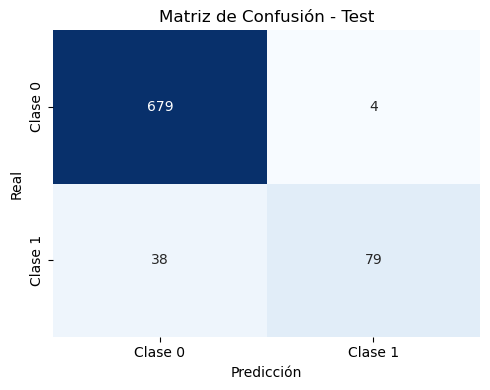

In [44]:
# Copiar base para H7
H7 = df.copy()

H7["HasIntPlanAndCalls"] = ((H7["International plan"] == "Yes") & (H7["Total intl calls"] > 0)).astype(int)

# 2. Target como entero si es booleano
y_rh7 = H7['Churn'].astype(int)
X_rh7 = H7.drop(columns=['Churn'])


X_rh7_train, X_rh7_test, y_rh7_train, y_test = train_test_split(X_rh7, y_rh7, test_size=0.3, random_state=42)

# Nuevo pipeline de procesamiento rh7
multicolumn_prep_rh7 = Pipeline([
    ('drop2', DropColumn(cols=columnas_innecesarias_h7)),
    ('drop3', DropColumn(cols=columnas_alta_correlacion)),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['Voice mail plan']),
            ('scale', StandardScaler(), [
'Number vmail messages',
 'Total day charge',
 'Total eve charge',
 'Total night charge',
 'Total intl charge',
 'Customer service calls'
            ])
        ],
        remainder='passthrough'
    ))
])

# Pipeline completo
rh7_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_rh7),
    ('rf_model', RandomForestClassifier(random_state=42))
])

# Hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Búsqueda aleatoria
rh7_random_search = RandomizedSearchCV(
    rh7_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
rh7_random_search.fit(X_rh7_train, y_rh7_train)
best_rh7_pipeline = rh7_random_search.best_estimator_

# Evaluación
y_rh7_train_pred = best_rh7_pipeline.predict(X_rh7_train)
y_rh7_test_pred = best_rh7_pipeline.predict(X_rh7_test)

print("🔧 Mejores hiperparámetros encontrados:")
print(rh7_random_search.best_params_)

print("\n📊 Precisión en Train:", precision_score(y_train, y_rh7_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh7_train_pred))
plot_confusion(y_train, y_rh7_train_pred, "Matriz de Confusión - Train")

print("\n📊 Precisión en Test:", precision_score(y_test, y_rh7_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh7_test_pred))
plot_confusion(y_test, y_rh7_test_pred, "Matriz de Confusión - Test")

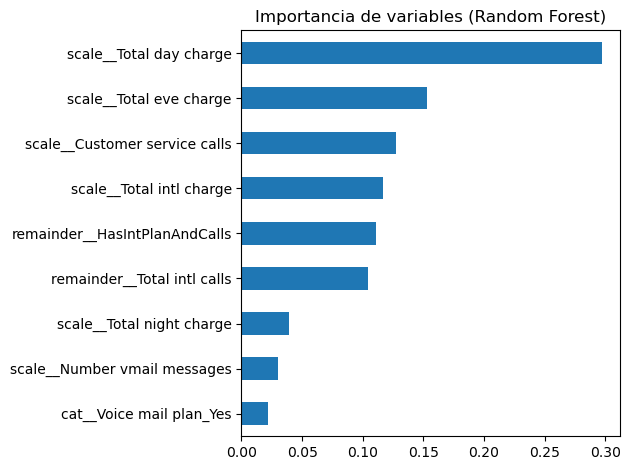

In [45]:
# Obtener el modelo RandomForest desde el pipeline
rf_rh7_model = best_rh7_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_rh7_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_rh7_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Mejora en ganancia neta: 156.74% - Ganancia h0: 1459200.0 - Ganancia h7: 3744000.0 - Ganancia Rh7: 3746400.0
Reducción en pérdida total: 56.94% - Pérdida h0: -760800.0 - Pérdida h7: -336000.0 - Pérdida Rh7: -327600.0


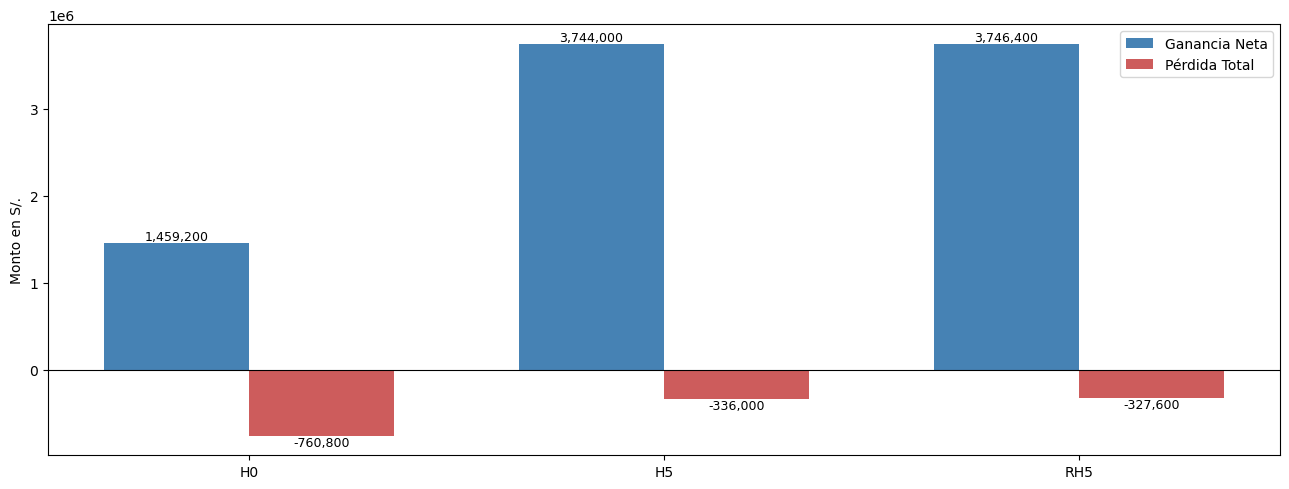

In [46]:
# Resultados finales
rh7_conf_matrix = confusion_matrix(y_test, y_rh7_test_pred)
rh7_conf_matrix_df = pd.DataFrame(rh7_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh7_resultado = calcular_business_value(rh7_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh7 = rh7_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh7 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh7 = rh7_resultado["perdida_fp"] + rh7_resultado["perdida_fn"] + rh7_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh7)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh7) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia h7: {ganancia_h7} - Ganancia Rh7: {ganancia_rh7}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida h7: {perdida_h7} - Pérdida Rh7: {perdida_rh7}")

evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h7,
    ganancia_rh7,
    perdida_h0,
    perdida_h7,
    perdida_rh7,
    5
)

## H4: Binarización de Number vmail messages en 0 (sin buzón) y >0 (con buzón)

### Original

In [47]:
H4=df.copy()

# Crear columna binaria: 0 si no tiene mensajes, 1 si tiene al menos uno
H4["HasVmail"] = (H4["Number vmail messages"] > 0).astype(int)

# Eliminar la columna original si no se necesita
H4.drop(columns=["Number vmail messages"], inplace=True)

H4_encoded = pd.get_dummies(H4.drop(columns=['Churn']), drop_first=True)

# 2. Target como entero si es booleano
y_h4 = H4['Churn'].astype(int)
X_h4 = H4_encoded

X_h4_train, X_h4_test, y_h4_train, y_h4_test = train_test_split(X_h4, y_h4, test_size=0.3, random_state=42)

# Definir el modelo base
h4_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h4_random_search = RandomizedSearchCV(
    h4_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h4_random_search.fit(X_h4_train, y_h4_train)

# Mejor modelo
best_rf_h4 = h4_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h4_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h4, X_h4, y_h4, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h4_y_train_pred = best_rf_h4.predict(X_h4_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h4_train, rf_h4_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h4_train, rf_h4_y_train_pred))

# Predicción
rf_h4_y_test_pred = best_rf_h4.predict(X_h4_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h4_test, rf_h4_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h4_test, rf_h4_y_test_pred))


h4_conf_matrix = confusion_matrix(y_h4_test, rf_h4_y_test_pred)
h4_conf_matrix_df = pd.DataFrame(h4_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h4_resultado = calcular_business_value(h4_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h4 = h4_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h4 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h4 = h4_resultado["perdida_fp"] + h4_resultado["perdida_fn"] + h4_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h4)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h4) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

# Resultados finales
print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h4}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h4}")

🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 222}
📈 Puntuaciones de cada fold (10-fold CV):
[0.87096774 0.90625    0.90322581 0.89285714 0.87878788 0.83783784
 0.91428571 0.96153846 0.92592593 1.        ]

📊 Precisión promedio: 90.92%
📉 Desviación estándar: 4.37%

📊 Precisión (positive class) en train: 98.65%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1595
           1       0.99      0.81      0.89       271

    accuracy                           0.97      1866
   macro avg       0.98      0.90      0.94      1866
weighted avg       0.97      0.97      0.97      1866


📊 Precisión (positive class) en test: 96.25%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       683
           1       0.96      0.66      0.78       117



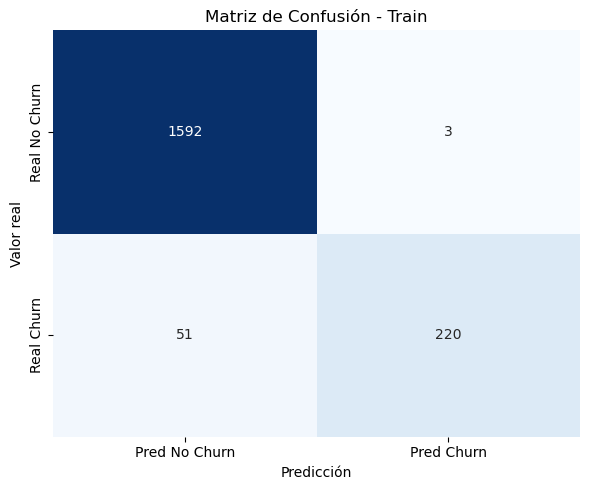

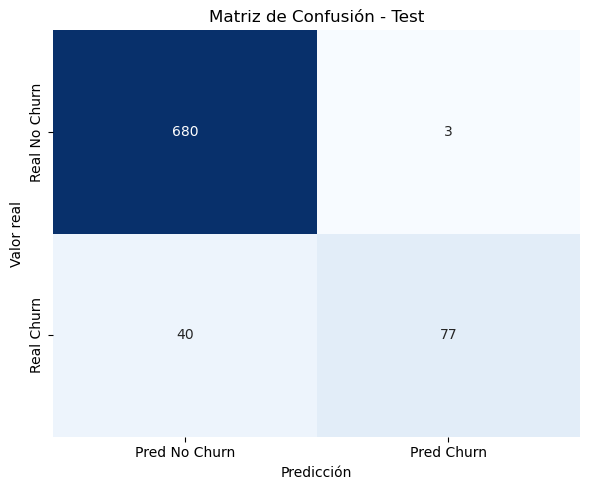

In [48]:
# 🔵 Matriz de confusión en TRAIN
h4_conf_matrix_train = confusion_matrix(y_h4_train, rf_h4_y_train_pred)
plot_confusion_matrix(h4_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h4_conf_matrix)
plot_confusion_matrix(h4_conf_matrix, title="Matriz de Confusión - Test")

### Rama de Nivel 4

In [49]:
columnas_innecesarias_h4=['State','Area code','Account length','Total day calls','Total eve calls','Total night calls']

In [50]:
columnas_filtradas = [col for col in df.columns
                      if col not in columnas_innecesarias_h7
                      and col not in columnas_alta_correlacion]
columnas_filtradas

['Voice mail plan',
 'Number vmail messages',
 'Total day charge',
 'Total eve charge',
 'Total night charge',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 6, 'rf_model__max_features': None, 'rf_model__min_samples_leaf': 3, 'rf_model__min_samples_split': 2, 'rf_model__n_estimators': 222}

📊 Precisión en Train: 0.9911111111111112
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.97      1.00      0.98      1595
        True       0.99      0.82      0.90       271

    accuracy                           0.97      1866
   macro avg       0.98      0.91      0.94      1866
weighted avg       0.97      0.97      0.97      1866



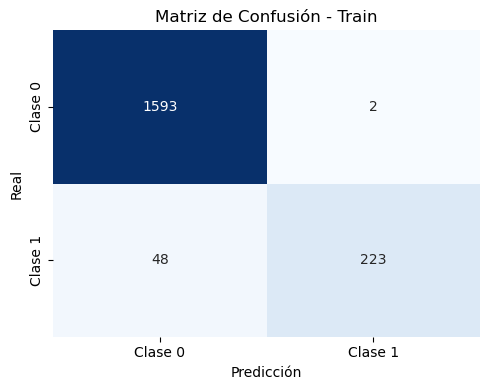


📊 Precisión en Test: 0.9512195121951219
🧾 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       683
           1       0.95      0.67      0.78       117

    accuracy                           0.95       800
   macro avg       0.95      0.83      0.88       800
weighted avg       0.95      0.95      0.94       800



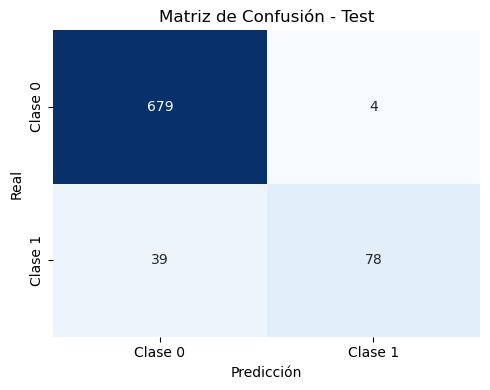

In [51]:
H4=df.copy()

# Crear columna binaria: 0 si no tiene mensajes, 1 si tiene al menos uno
H4["HasVmail"] = (H4["Number vmail messages"] > 0).astype(int)

# 2. Target como entero si es booleano
y_rh4 = H4['Churn'].astype(int)
X_rh4 = H4.drop(columns=['Churn'])


X_rh4_train, X_rh4_test, y_rh4_train, y_test = train_test_split(X_rh4, y_rh4, test_size=0.3, random_state=42)

# Nuevo pipeline de procesamiento rh4
multicolumn_prep_rh4 = Pipeline([
    ('drop2', DropColumn(cols=columnas_innecesarias_h4)),
    ('drop3', DropColumn(cols=columnas_alta_correlacion)),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan','HasVmail']),
            ('scale', StandardScaler(), [
              'Number vmail messages',
              'Total day charge',
              'Total eve charge',
              'Total night charge',
              'Total intl calls',
              'Total intl charge',
              'Customer service calls'
            ])
        ],
        remainder='passthrough'
    ))
])

# Pipeline completo
rh4_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_rh4),
    ('rf_model', RandomForestClassifier(random_state=42))
])

# Hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Búsqueda aleatoria
rh4_random_search = RandomizedSearchCV(
    rh4_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenamiento
rh4_random_search.fit(X_rh4_train, y_rh4_train)
best_rh4_pipeline = rh4_random_search.best_estimator_

# Evaluación
y_rh4_train_pred = best_rh4_pipeline.predict(X_rh4_train)
y_rh4_test_pred = best_rh4_pipeline.predict(X_rh4_test)

print("🔧 Mejores hiperparámetros encontrados:")
print(rh4_random_search.best_params_)

print("\n📊 Precisión en Train:", precision_score(y_train, y_rh4_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh4_train_pred))
plot_confusion(y_train, y_rh4_train_pred, "Matriz de Confusión - Train")

print("\n📊 Precisión en Test:", precision_score(y_test, y_rh4_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh4_test_pred))
plot_confusion(y_test, y_rh4_test_pred, "Matriz de Confusión - Test")

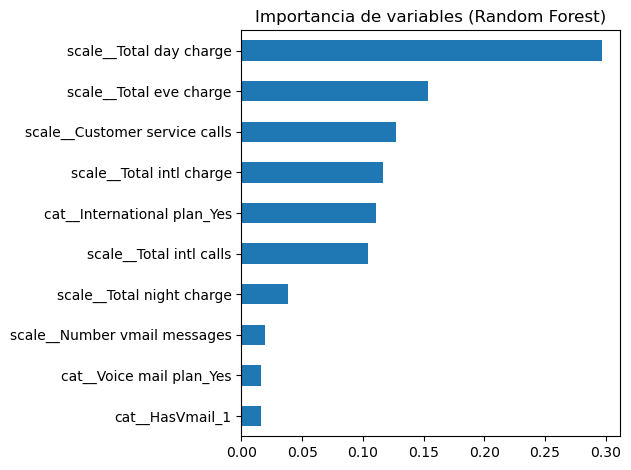

In [52]:
# Obtener el modelo RandomForest desde el pipeline
rf_rh4_model = best_rh4_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_rh4_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_rh4_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Mejora en ganancia neta: 156.41% - Ganancia h0: 1459200.0 - Ganancia h4: 3744000.0 - Ganancia Rh4: 3741600.0
Reducción en pérdida total: 56.31% - Pérdida h0: -760800.0 - Pérdida h4: -336000.0 - Pérdida Rh4: -332400.0


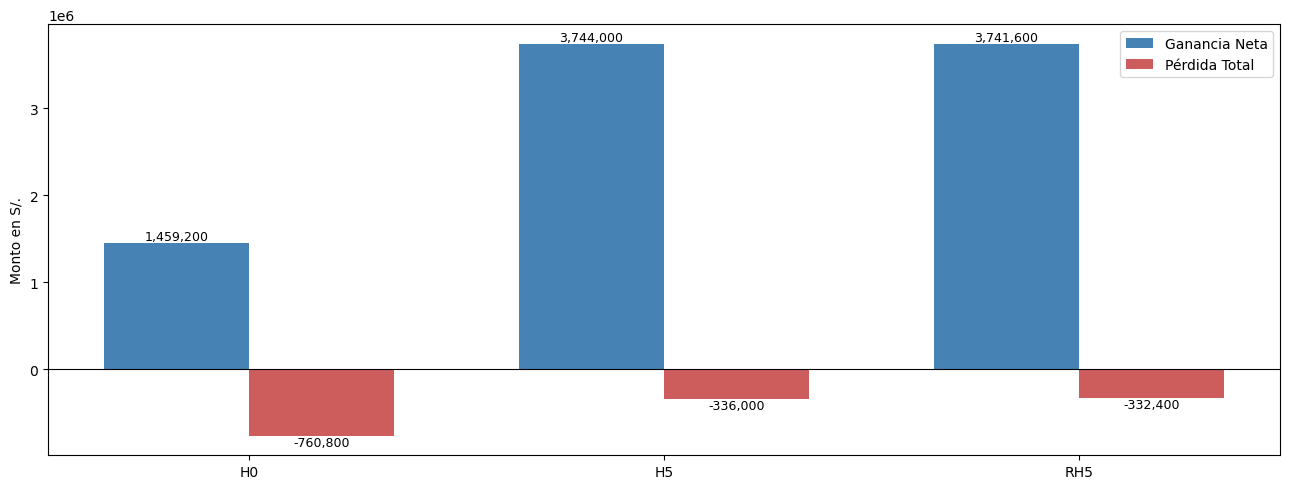

In [53]:
# Resultados finales
rh4_conf_matrix = confusion_matrix(y_test, y_rh4_test_pred)
rh4_conf_matrix_df = pd.DataFrame(rh4_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh4_resultado = calcular_business_value(rh4_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh4 = rh4_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh4 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh4 = rh4_resultado["perdida_fp"] + rh4_resultado["perdida_fn"] + rh4_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh4)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh4) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia h4: {ganancia_h4} - Ganancia Rh4: {ganancia_rh4}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida h4: {perdida_h4} - Pérdida Rh4: {perdida_rh4}")

evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h4,
    ganancia_rh4,
    perdida_h0,
    perdida_h4,
    perdida_rh4,
    5
)

## H9: Simulación de campaña promocional (PromoImpact) aleatoria al 10% de los registros

### Hipotesis Inicial

In [54]:
# Copiar base para h9
h9 = df.copy()
h9["PromoImpact"] = 0
np.random.seed(42)
promo_indices = np.random.choice(h9.index, size=int(0.1 * len(h9)), replace=False)
h9.loc[promo_indices, "PromoImpact"] = 1
h9_encoded = pd.get_dummies(h9.drop(columns=['Churn']), drop_first=True)
y_h9 = h9['Churn'].astype(int)
X_h9 = h9_encoded

X_h9_train, X_h9_test, y_h9_train, y_h9_test = train_test_split(X_h9, y_h9, test_size=0.3, random_state=42)

# Definir el modelo base
h9_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h9_random_search = RandomizedSearchCV(
    h9_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h9_random_search.fit(X_h9_train, y_h9_train)

# Mejor modelo
best_rf_h9 = h9_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h9_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h9, X_h9, y_h9, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h9_y_train_pred = best_rf_h9.predict(X_h9_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h9_train, rf_h9_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h9_train, rf_h9_y_train_pred))

# Predicción
rf_h9_y_test_pred = best_rf_h9.predict(X_h9_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h9_test, rf_h9_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h9_test, rf_h9_y_test_pred))

h9_conf_matrix = confusion_matrix(y_h9_test, rf_h9_y_test_pred)
h9_conf_matrix_df = pd.DataFrame(h9_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h9_resultado = calcular_business_value(h9_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h9 = h9_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h9 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h9 = h9_resultado["perdida_fp"] + h9_resultado["perdida_fn"] + h9_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h9)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h9) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

# Resultados finales
print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h9}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h9}")

🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 187}
📈 Puntuaciones de cada fold (10-fold CV):
[0.86666667 0.93333333 0.92592593 0.92592593 0.82857143 0.81578947
 0.91176471 0.96153846 0.92857143 1.        ]

📊 Precisión promedio: 90.98%
📉 Desviación estándar: 5.44%

📊 Precisión (positive class) en train: 96.38%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1595
           1       0.96      0.79      0.87       271

    accuracy                           0.96      1866
   macro avg       0.96      0.89      0.92      1866
weighted avg       0.96      0.96      0.96      1866


📊 Precisión (positive class) en test: 90.24%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       683
           1       0.90      0.63      0.74       117



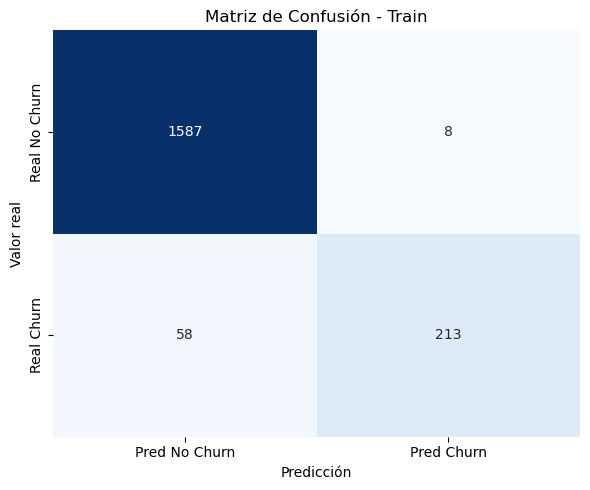

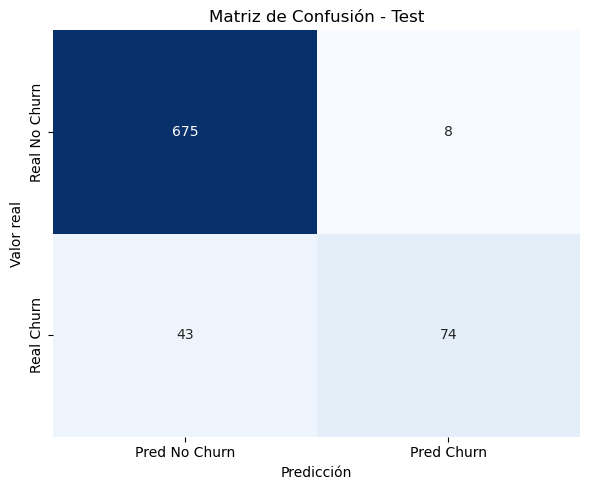

In [55]:
# 🔵 Matriz de confusión en TRAIN
h9_conf_matrix_train = confusion_matrix(y_h9_train, rf_h9_y_train_pred)
plot_confusion_matrix(h9_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h9_conf_matrix)
plot_confusion_matrix(h9_conf_matrix, title="Matriz de Confusión - Test")

### Rama de Nivel 4

In [56]:
columnas_innecesarias_h9=['State','Area code','Account length','Total day calls','Total eve calls','Total night calls']

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 5, 'rf_model__max_features': None, 'rf_model__min_samples_leaf': 3, 'rf_model__min_samples_split': 4, 'rf_model__n_estimators': 207}

📊 Precisión en Train: 0.16143497757847533
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.86      0.88      0.87      1595
        True       0.16      0.13      0.15       271

    accuracy                           0.77      1866
   macro avg       0.51      0.51      0.51      1866
weighted avg       0.76      0.77      0.76      1866



/home/ubuntu/miniforge3/envs/proyecto_grupo3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


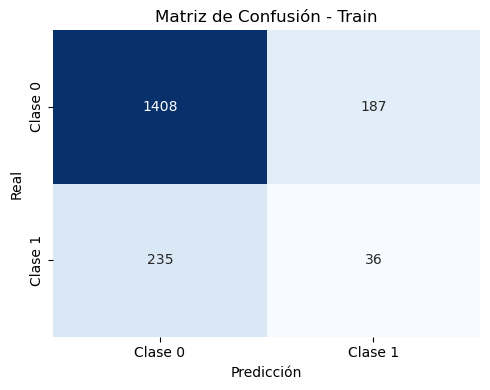


📊 Precisión en Test: 0.8817204301075269
🧾 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       693
           1       0.88      0.77      0.82       107

    accuracy                           0.95       800
   macro avg       0.92      0.88      0.90       800
weighted avg       0.95      0.95      0.95       800



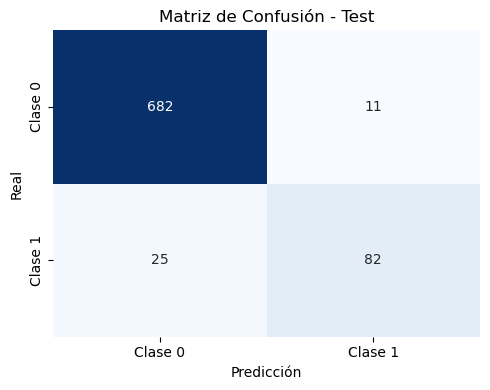

In [57]:
H9 = df.copy()
H9["PromoImpact"] = 0
np.random.seed(92)
promo_indices = np.random.choice(H9.index, size=int(0.1 * len(H9)), replace=False)
H9.loc[promo_indices, "PromoImpact"] = 1

# 2. Target como entero si es booleano
y_rh9 = H9['Churn'].astype(int)
X_rh9 = H9.drop(columns=['Churn'])

X_rh9_train, X_rh9_test, y_rh9_train, y_test = train_test_split(X_rh9, y_rh9, test_size=0.3, random_state=92)

# Nuevo pipeline de procesamiento rh9
multicolumn_prep_rh9 = Pipeline([
    ('drop2', DropColumn(cols=columnas_innecesarias_h9)),
    ('drop3', DropColumn(cols=columnas_alta_correlacion)),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan','PromoImpact']),
            ('scale', StandardScaler(), [
              'Number vmail messages',
              'Total day charge',
              'Total eve charge',
              'Total night charge',
              'Total intl calls',
              'Total intl charge',
              'Customer service calls'
            ])
        ],
        remainder='passthrough'
    ))
])

# Pipeline completo
rh9_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_rh9),
    ('rf_model', RandomForestClassifier(random_state=92))
])

# Hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Búsqueda aleatoria
rh9_random_search = RandomizedSearchCV(
    rh9_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=92,
    n_jobs=-1
)

# Entrenamiento
rh9_random_search.fit(X_rh9_train, y_rh9_train)
best_rh9_pipeline = rh9_random_search.best_estimator_

# Evaluación
y_rh9_train_pred = best_rh9_pipeline.predict(X_rh9_train)
y_rh9_test_pred = best_rh9_pipeline.predict(X_rh9_test)

print("🔧 Mejores hiperparámetros encontrados:")
print(rh9_random_search.best_params_)

print("\n📊 Precisión en Train:", precision_score(y_train, y_rh9_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh9_train_pred))
plot_confusion(y_train, y_rh9_train_pred, "Matriz de Confusión - Train")

print("\n📊 Precisión en Test:", precision_score(y_test, y_rh9_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh9_test_pred))
plot_confusion(y_test, y_rh9_test_pred, "Matriz de Confusión - Test")

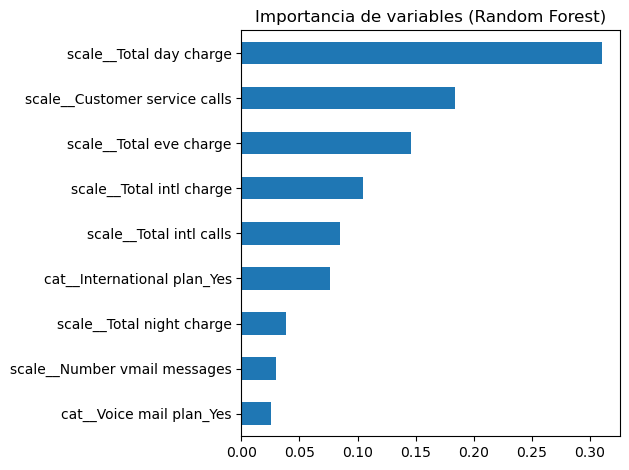

In [58]:
# Obtener el modelo RandomForest desde el pipeline
rf_rh9_model = best_rh9_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_rh9_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_rh9_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Mejora en ganancia neta: 162.50% - Ganancia h0: 1459200.0 - Ganancia h4: 3693600.0 - Ganancia rh9: 3830400.0
Reducción en pérdida total: 65.62% - Pérdida h0: -760800.0 - Pérdida h4: -356400.0 - Pérdida rh9: -261600.0


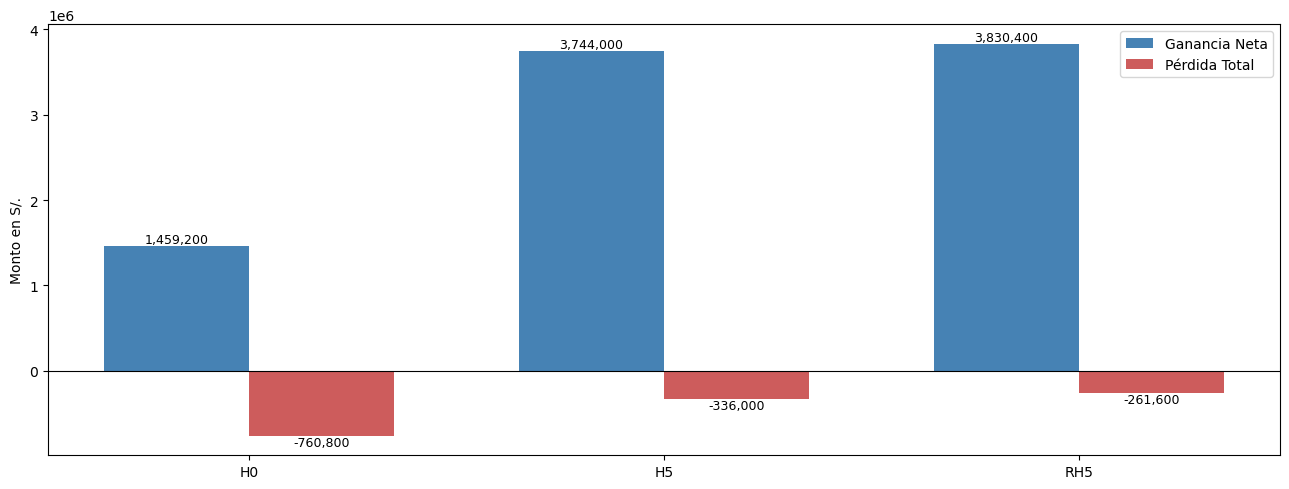

In [59]:
# Resultados finales
rh9_conf_matrix = confusion_matrix(y_test, y_rh9_test_pred)
rh9_conf_matrix_df = pd.DataFrame(rh9_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh9_resultado = calcular_business_value(rh9_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh9 = rh9_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh9 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh9 = rh9_resultado["perdida_fp"] + rh9_resultado["perdida_fn"] + rh9_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh9)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh9) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia h4: {ganancia_h9} - Ganancia rh9: {ganancia_rh9}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida h4: {perdida_h9} - Pérdida rh9: {perdida_rh9}")

evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h4,
    ganancia_rh9,
    perdida_h0,
    perdida_h4,
    perdida_rh9,
    5
)

## ANALAISIS VB

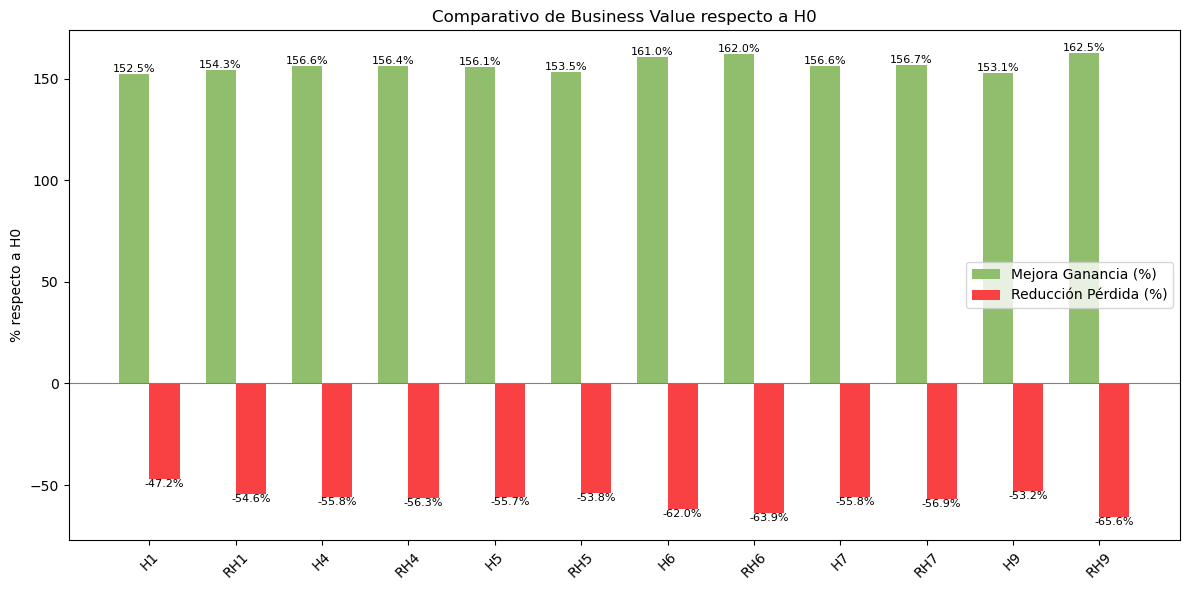

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionarios con ganancias y pérdidas por hipótesis
ganancias = {
    'H1': ganancia_h1,
    'RH1': ganancia_rh1,
    'H4': ganancia_h4,
    'RH4': ganancia_rh4,
    'H5': ganancia_h5,
    'RH5': ganancia_rh5,
    'H6': ganancia_h6,
    'RH6': ganancia_rh6,
    'H7': ganancia_h7,
    'RH7': ganancia_rh7,
    'H9': ganancia_h9,
    'RH9': ganancia_rh9,
}

perdidas = {
    'H1': perdida_h1,
    'RH1': perdida_rh1,
    'H4': perdida_h4,
    'RH4': perdida_rh4,
    'H5': perdida_h5,
    'RH5': perdida_rh5,
    'H6': perdida_h6,
    'RH6': perdida_rh6,
    'H7': perdida_h7,
    'RH7': perdida_rh7,
    'H9': perdida_h9,
    'RH9': perdida_rh9,
}

# Calcular % de mejora y reducción vs H0
mejoras_ganancia = {k: ((v - ganancia_h0) / ganancia_h0) * 100 for k, v in ganancias.items()}
reducciones_perdida = {k: ((perdida_h0 - v) / abs(perdida_h0)) * 100 for k, v in perdidas.items()}

# Preparar datos para el gráfico
labels = list(mejoras_ganancia.keys())
ganancia_vals = [mejoras_ganancia[k] for k in labels]
perdida_vals = [reducciones_perdida[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, ganancia_vals, width, label='Mejora Ganancia (%)', color='#90be6d')
bars2 = ax.bar(x + width/2, perdida_vals, width, label='Reducción Pérdida (%)', color='#f94144')

# Estética
ax.set_ylabel('% respecto a H0')
ax.set_title('Comparativo de Business Value respecto a H0')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.axhline(0, color='gray', linewidth=0.8)
ax.legend()

# Etiquetas sobre las barras
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval,
            f'{yval:.1f}%', ha='center',
            va='bottom' if yval > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()


In [61]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Lista de hipótesis y ramas disponibles
modelos = list(ganancias.keys())

# Widget desplegable
selector_modelo = widgets.Dropdown(
    options=modelos,
    value='RH6',
    description='Modelo:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

# Función para mostrar resultados
def mostrar_resultados(modelo):
    ganancia = ganancias[modelo]
    perdida = perdidas[modelo]

    mejora_ganancia = ((ganancia - ganancia_h0) / abs(ganancia_h0)) * 100
    reduccion_perdida = ((perdida_h0 - perdida) / abs(perdida_h0)) * 100

    display(Markdown(f"""
    ### 📊 Resultados para `{modelo}`
    - **Ganancia neta:** S/. {ganancia:,.2f}
    - **Pérdida total:** S/. {perdida:,.2f}
    - **Mejora en ganancia neta:** {mejora_ganancia:.2f}%
    - **Reducción en pérdida total:** {reduccion_perdida:.2f}%
    """))

    # Gráfico comparativo
    fig, ax = plt.subplots(figsize=(6, 4))
    barras = ax.bar(['Ganancia', 'Pérdida'], [ganancia, perdida], color=['green', 'red'])
    ax.set_title(f'Business Value: {modelo}')
    ax.axhline(0, color='black', linewidth=0.8)
    for bar in barras:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 50000, f'{yval:,.0f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    # Conclusión automática para RH6
    if modelo == 'RH6':
        display(Markdown("✅ **Conclusión**: Se recomienda **RH6** porque es el modelo más generalizable y estable según su rendimiento económico."))

# Mostrar interactivo
widgets.interact(mostrar_resultados, modelo=selector_modelo)

interactive(children=(Dropdown(description='Modelo:', index=7, layout=Layout(width='40%'), options=('H1', 'RH1…

<function __main__.mostrar_resultados(modelo)>